# Analyze Zacros kMC trajectories data for O-Pt(111)

In [1]:
import numpy as np
from pathlib  import Path
import json
import pandas as pd
import matplotlib.pyplot as plt
import zacros_functions as zf

In [ ]:
def get_lattice_xy(path):
   # Get lattice-site coordinates
   lattice_output_file = path / 'lattice_output.txt'
   try:
      lattice = np.loadtxt(lattice_output_file, usecols=(1,2),skiprows=2)
      with open(lattice_output_file) as f:
         v1 = np.array(f.readline().split()[1:3], dtype=float)
         v2 = np.array(f.readline().split()[1:3], dtype=float)
   except:
      lattice, v1, v2 = None, None, None

   return lattice, v1, v2

def get_ads_info(trajdir, idx=None):
   """
   Produces cartesian coordinates of adsorbates from history_output.txt
   Parameters
   ----------
   trajdir : str or Path
      Path to the Zacros simulation folder.
   idx : int, optional : which configuration to extract (default is None, meaning all snapshots)
   Returns
   -------
   ads_info : np.array
      (List of) Array(s) of cartesian coordinates of adsorbates in the specified configuration.
   """

   # Read lattice input file

   try:
      with open(trajdir / 'lattice_input.dat', 'r') as f:
         content = [line for line in f.readlines() if (line.strip() and not line.startswith('#'))]
   except FileNotFoundError:
      raise FileNotFoundError(f"Lattice input file '{lattice_input_file}' not found.")
   finally:
      content = [line.split('#')[0] for line in content]

   for i,line in enumerate(content):
         if 'cell_vectors' in line:
               unit_cell = np.array([ [float(x) for x in content[i+1].split()],
                           [float(x) for x in content[i+2].split()] ])
         if 'repeat_cell' in line:
               repeat_cell = np.array([ int(x) for x in line.split()[1:3] ])
         if 'n_site_types' in line:
               n_site_types = int(line.split()[1])
         if 'n_cell_sites' in line:
               n_cell_sites = int(line.split()[1])
         if 'site_types' in line:
               site_types_names = line.split()[1:]
         if 'site_coordinates' in line:
               site_coordinates = []
               for j in range(n_cell_sites):
                  site_coordinates.append([float(x) for x in content[i+1+j].split()[:2]])
               site_uc_coordinates = np.array(site_coordinates) @ unit_cell


   site_coordinates = []
   site_types = []
   for i in range(repeat_cell[0]):
      for j in range(repeat_cell[1]):
         shift = np.array([i,j]) @ unit_cell
         for coords,st in zip(site_uc_coordinates , site_types_names):
               site_types.append(st)
               site_coordinates.append(coords + shift)
               site_types.append(st)

   # Read configurations from history_output.txt file

   try:
      with open(trajdir / 'history_output.txt', 'r') as f:
         content = f.readlines()
   except FileNotFoundError:
      print(f" File '{trajdir / 'history_output.txt'}' not found.")
   finally:

      # Get the species list
      species = content[1].split()[1:]
      # Set number of sites
      n_sites = repeat_cell[0] * repeat_cell[1] * n_cell_sites

      if idx is None:
         # Get number of configurations
         for line in content:
            if 'configuration' in line:
               n_confs = int(line.split()[1])
         confs = np.zeros((n_confs, n_sites), dtype=int)
         for i_conf in range(n_confs):
            for i in range(n_sites):
               confs[i_conf, i] = int(content[7 + i_conf*(n_sites+1) +i].split()[2])
      else:
         confs = np.zeros((1, n_sites), dtype=int)
         for i in range(n_sites):
            confs[0, i] = int(content[7 + idx*(n_sites+1) +i].split()[2])

   # adsorbate coordinates and sites
   ads_info = []
   for conf in confs:
      ads_info.append(np.array([ i, site_coordinates[i], site_types[i], occ for i, occ in enumerate(conf) if (occ > 0)]))

   return ads_info 


def get_accessibility(points, v1, v2, distance, tolerance=0.001):
    
   """
   Cluster 2D points with periodic boundary conditions.
   Parameters
   ----------
   points : (N,2) array_like
      Cartesian coordinates of points (float).
   v1, v2 : The box is spanned by v1 and v2.
   cutoff : float
      Distance cutoff for connectivity (e.g. 3rd NN distance).

   Returns
   -------
   labels : (N,) int
      Cluster label for each original point (0..nclusters-1).
   clusters : list of ndarray
      Indices of points in each cluster.
   sizes : list of int 
      Sizes of clusters (only if return_sizes True).
   """

   from scipy.spatial import cKDTree

   pts = np.asarray(points, dtype=float)
   if pts.size == 0:
      return np.array([], dtype=int), [], []

   N = len(pts)
   # Build augmented points = original points shifted by translations i*v1 + j*v2 with i,j in {-1,0,1}
   shifts = [(i, j) for i in (-1, 0, 1) for j in (-1, 0, 1)]
   aug_pts = np.zeros((N * len(shifts), 2), dtype=float)
   orig_idx = np.zeros(N * len(shifts), dtype=int)

   k = 0
   for si, (i, j) in enumerate(shifts):
      shift_vec = i * v1 + j * v2
      aug_pts[k:k+N] = pts + shift_vec
      orig_idx[k:k+N] = np.arange(N)
      k += N

   # KD-tree on augmented points
   tree = cKDTree(aug_pts)

   # List of pairs inside of distance+ and distance-
   pairs_out = tree.query_pairs((1+tolerance)*distance, output_type='ndarray')  # array of shape (M,2)
   pairs_in  = tree.query_pairs((1-tolerance)*distance, output_type='ndarray')  # array of shape (M,2)
   # Remove elements of pairs_in from pairs_out with set difference
   pairs = set([tuple(x) for x in pairs_out]) - set([tuple(x) for x in pairs_in]) 

   pairs_clean = set()
   for a, b in pairs:
      ia = orig_idx[a]
      ib = orig_idx[b]
      if ia != ib:
         pairs_clean.add((ia, ib))

   acc = np.zeros(N, dtype=int)
   for i in np.arange(N):
      acc[i] = 6 - len([r for r in pairs_clean if r[0] == i or r[1] == i])


   return acc

def cluster_info_periodic(points, v1, v2, distance, tolerance=0.001, n_neighbors=6):
   """
   Cluster 2D points with periodic boundary conditions
   and calculate accessibility for each point

   Parameters
   ----------
   points : (N,2) array_like
      Cartesian coordinates of points (float).
   v1, v2 : The box is spanned by v1 and v2.
   distance : float
      Distance for connectivity (e.g. 3rd NN distance).
   tolerance : float, optional 
      tolerance for the distance (default: 0.001 of distance)
   n_neighbors: int, optional 
      maximum number of available sites at the distance (default: 6)

   Returns
   -------
   labels : (N,) int
      Cluster label for each original point (0..nclusters-1).
   clusters : list of ndarray
      Indices of points in each cluster.
   sizes : list of int 
      Sizes of clusters.
   acc : (N,) int
      Accessibility value for each point
   """

   from scipy.spatial import cKDTree

   pts = np.asarray(points, dtype=float)
   if pts.size == 0:
      return np.array([], dtype=int), [], []

   N = len(pts)
   # Build augmented points = original points shifted by translations i*v1 + j*v2 with i,j in {-1,0,1}
   shifts = [(i, j) for i in (-1, 0, 1) for j in (-1, 0, 1)]
   aug_pts = np.zeros((N * len(shifts), 2), dtype=float)
   orig_idx = np.zeros(N * len(shifts), dtype=int)

   k = 0
   for si, (i, j) in enumerate(shifts):
      shift_vec = i * v1 + j * v2
      aug_pts[k:k+N] = pts + shift_vec
      orig_idx[k:k+N] = np.arange(N)
      k += N

   # KD-tree on augmented points
   tree = cKDTree(aug_pts)

   # List of pairs inside outer and inner circles embracing the distance
   pairs_out = tree.query_pairs((1.0+tolerance)*distance, output_type='ndarray')  # array of shape (M,2)
   pairs_in  = tree.query_pairs((1.0-tolerance)*distance, output_type='ndarray')  # array of shape (M,2)

   # Cluster sizes

   uf = zf.UnionFind(N)
   for a, b in pairs_out:
      ia = orig_idx[a]
      ib = orig_idx[b]
      if ia != ib:
         uf.union(ia, ib)

   # Extract roots and relabel to contiguous labels
   roots = np.array([uf.find(i) for i in range(N)])
   unique_roots, inv = np.unique(roots, return_inverse=True)
   labels = inv
   clusters = [np.nonzero(labels == k)[0] for k in range(len(unique_roots))]
   sizes = [len(c) for c in clusters]

   # Accessibilities

   # Remove elements of pairs_in from pairs_out with set difference
   pairs = set([tuple(x) for x in pairs_out]) - set([tuple(x) for x in pairs_in]) 

   pairs_clean = set()
   for a, b in pairs:
      ia = orig_idx[a]
      ib = orig_idx[b]
      if ia != ib:
         pairs_clean.add((ia, ib))

   acc = np.zeros(N, dtype=int)
   for i in np.arange(N):
      acc[i] = n_neighbors - len([r for r in pairs_clean if r[0] == i or r[1] == i])

   return labels, clusters, sizes, acc

def accessibility_periodic(lattice_state, clusters, ncols, nrows, nsites_cell):

   directions = np.asarray([(1, 0), (0, 1), (-1, 1), (-1, 0), (0, -1), (1, -1)], dtype=int)

   lattice_state = np.asarray(lattice_state, dtype=int)
   accessibilities = []
   for cluster in clusters:
      acc = []
      print(f'cluster: {cluster}')
      for site in cluster:

         nrows1 = nrows*nsites_cell
         col = site // nrows1
         row = site % nrows1

         nn1_list = [       row + x - ((row + x)//nrows1)*nrows1 + 
                     nrows1*(col + y - ((col + y)//ncols)*ncols  ) for x,y in directions]
         nn3_list = [       row + x - ((row + x)//nrows)*nrows + 
                     nrows1*(col + y - ((col + y)//ncols)*ncols  ) for x,y in 2*directions]

         print(f'site: {site}')
         print(f'nn1_list: {nn1_list}')
         print(f'nn3_list: {nn3_list}')
         print(f'states 1: {lattice_state[nn1_list]}, states 3: {lattice_state[nn3_list]}')
         print(f'# of nonzeros: {len(directions) - np.count_nonzero(lattice_state[nn1_list] + lattice_state[nn3_list])}')

         acc.append(len(directions) - np.count_nonzero(lattice_state[nn1_list] + lattice_state[nn3_list]))
      accessibilities.extend(acc)

   return accessibilities


def cluster_accessibility_periodic_avg(confs, lattice_states, v1, v2, ncols, nrows, nsites_cell, cutoff, nbins=20):
   """
   Compute cluster accessibilities averaged over confs.

   Returns:
   accessibilities averaged over all configurations in confs.
   """

   nsites = ncols*nrows*nsites_cell
   # Initialize arrays for averages
   sizes_avg = np.zeros(nsites)
   accs_avg = np.zeros(nsites)
   # Initialize histogram (6 is the max number of 3nn for fcc(111)), one for a good measure
   edges = np.linspace(0, 6+1, nbins+1)
   accs_hist = np.zeros(len(edges)-1)

   for ip, points in enumerate(confs):

      labels, clusters, sizes = zf.cluster_points_periodic(points, v1, v2, cutoff=cutoff)

      acc = accessibility_periodic(lattice_states[ip], clusters, ncols, nrows, nsites_cell)

      acc_cluster = [ np.sum(a)/size for a, size in zip(acc, sizes)]

      for i in np.arange(len(clusters)): 
         if sizes[i] > 0:
            print(f' Cluster {clusters[i]} with accs {acc[i]} ({acc_cluster[i]}) has a size of {sizes[i]} in conf #{ip}')

      # Collecting contributions into histogram
      bin_index = np.digitize(acc_cluster, edges, right=False) - 1
      for bin_idx in bin_index: accs_hist[bin_idx] += 1

      # Calculate average counts for cluster sizes
      for i, size in enumerate(sizes): 
         sizes_avg[size-1] += 1
         accs_avg[size-1] += sum(acc[clusters[i]])/size

   bin_centers = 0.5 * (edges[:-1] + edges[1:])

   sizes_avg /= len(confs)
   accs_avg  /= len(confs)
   accs_hist /= len(confs)


   return sizes_avg, accs_avg, bin_centers, accs_hist


In [3]:
# Time binning parameters
n_bins = 100

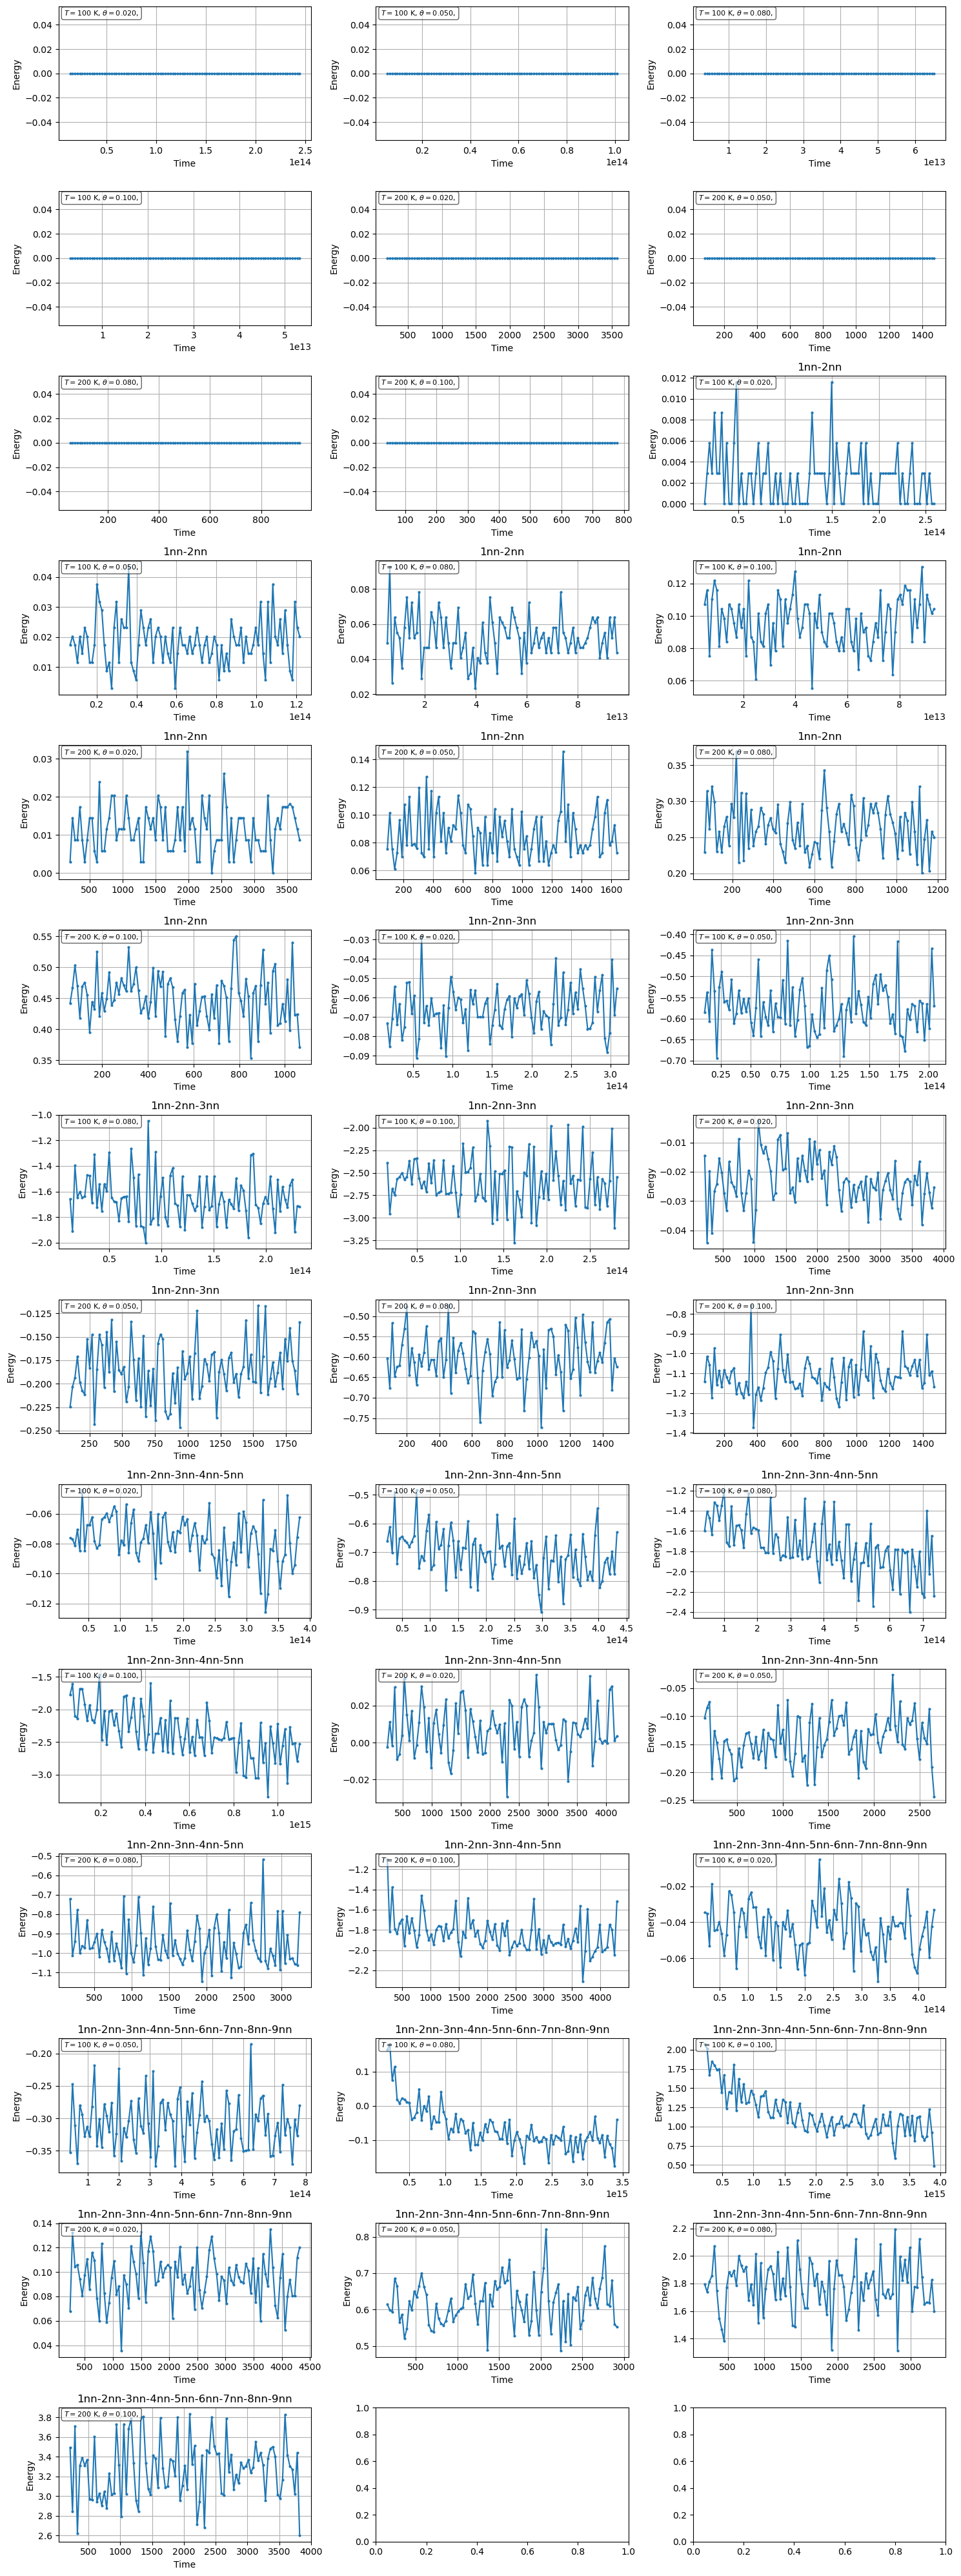

In [4]:
# Set directories and file names
# and get the starting point for equilibrium
# from the averaged energy plots

log_dir = Path.cwd() / 'zacros_calculations'
data_dir = log_dir / 'jobs'
results_dir = log_dir / 'results'
log_file = log_dir / 'jobs.log'

# Verify the file exists
if not log_file.exists():
    raise FileNotFoundError(f"Log file not found: {log_file}")

# Load json log file
with open(log_file, 'r') as f:
   log_header = f.readline().split()  # Read header
   log_entries = [json.loads(line) for line in f if line.strip()]

Path.mkdir(results_dir, exist_ok=True)
# Analyze data
run_dirs =[data_dir / str(entry[0]) for entry in log_entries]
temperatures = [entry[4] for entry in log_entries]
lat_size = [entry[2][0]*entry[2][1] for entry in log_entries]
n_ads = [entry[3][0] for entry in log_entries]
interactions = ['-'.join(entry[5][1:]) for entry in log_entries]
coverages = [n_ads[i]/lat_size[i] for i in range(len(n_ads))]

ncols = 3
fig, axes = plt.subplots(int(np.ceil(len(run_dirs)/ncols)), ncols, figsize=(15,40))

for ir,rundir in enumerate(run_dirs):

   # Check if the run was analyzed
   if (results_dir / f'{rundir.name}_{zf.en_file_suffix}').exists():
      # print(f' Using the processed data from {results_dir} for {rundir.name}')
      time_bin_centers, energy_hist = np.loadtxt(
                           results_dir / f'{rundir.name}_{zf.en_file_suffix}', unpack=True)

   else:
      # print(f' Processing trajectories from {rundir.name}...')
      # Get list of trajectories
      traj_files = list(rundir.rglob('history_output.txt'))

      # Get number of configurations and maximum kmc time for all trajectories
      nconfs = []
      end_time = np.inf
      for traj_file in traj_files:
         with open(traj_file) as f:
            for line in f: 
               if 'configuration' in line: 
                  confs = int(line.split()[1])
                  conf_time = float(line.split()[3])
         end_time = min(end_time, conf_time)
         nconfs.append(confs)

      time_bins   = np.linspace(0, end_time, n_bins+1)
      energy_hist = np.zeros(n_bins)
      for traj_file, confs in zip(traj_files,nconfs):

         time   = np.zeros(confs)
         energy = np.zeros(confs)

         # Get lattice-site coordinates
         try:
            lattice = np.loadtxt(traj_file.parent / 'lattice_output.txt', usecols=(1,2),skiprows=2)
            nsites  = len(lattice)
         except Exception:
            raise FileNotFoundError('lattice_output.txt not found in ' + str(traj_file.parent))
         
         # Get adsorbate positions
         counter = 0
         with open(traj_file) as f:
            for line in f:
                  if 'configuration' in line:
                     time[counter]   = float(line.split()[3])
                     energy[counter] = float(line.split()[5])
                     counter += 1

         # Create average energy histogram with n_bins
         for i in range(confs):
            bin_index = np.digitize(time[i], time_bins,right=False) - 1
            if bin_index < confs: energy_hist[bin_index] += energy[i]

      energy_hist /= len(nconfs)
      # Save processed data
      time_bin_centers = 0.5 * (time_bins[:-1] + time_bins[1:])
      np.savetxt(results_dir / f'{rundir.name}_{zf.en_file_suffix}', 
                 np.column_stack((time_bin_centers, energy_hist)), 
                 header='Time_s Energy_eV')

   # Plot energy as function of time using subplots
   ax = axes[ir//ncols, ir%ncols]
   ax.plot(time_bin_centers[5:], energy_hist[5:], marker='o', linestyle='-', markersize=2)
   ax.set_xlabel('Time')
   ax.set_ylabel('Energy')
   ax.set_title(f'{interactions[ir]}')
   ax.text(0.02, 0.98, fr'$T={temperatures[ir]}$ K, $\theta={coverages[ir]:.3f}$, ',
             transform=ax.transAxes,
             va='top', ha='left',
             fontsize=8,
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.6))

   ax.grid()

plt.tight_layout()
plt.show()

Radial Distribution Functions

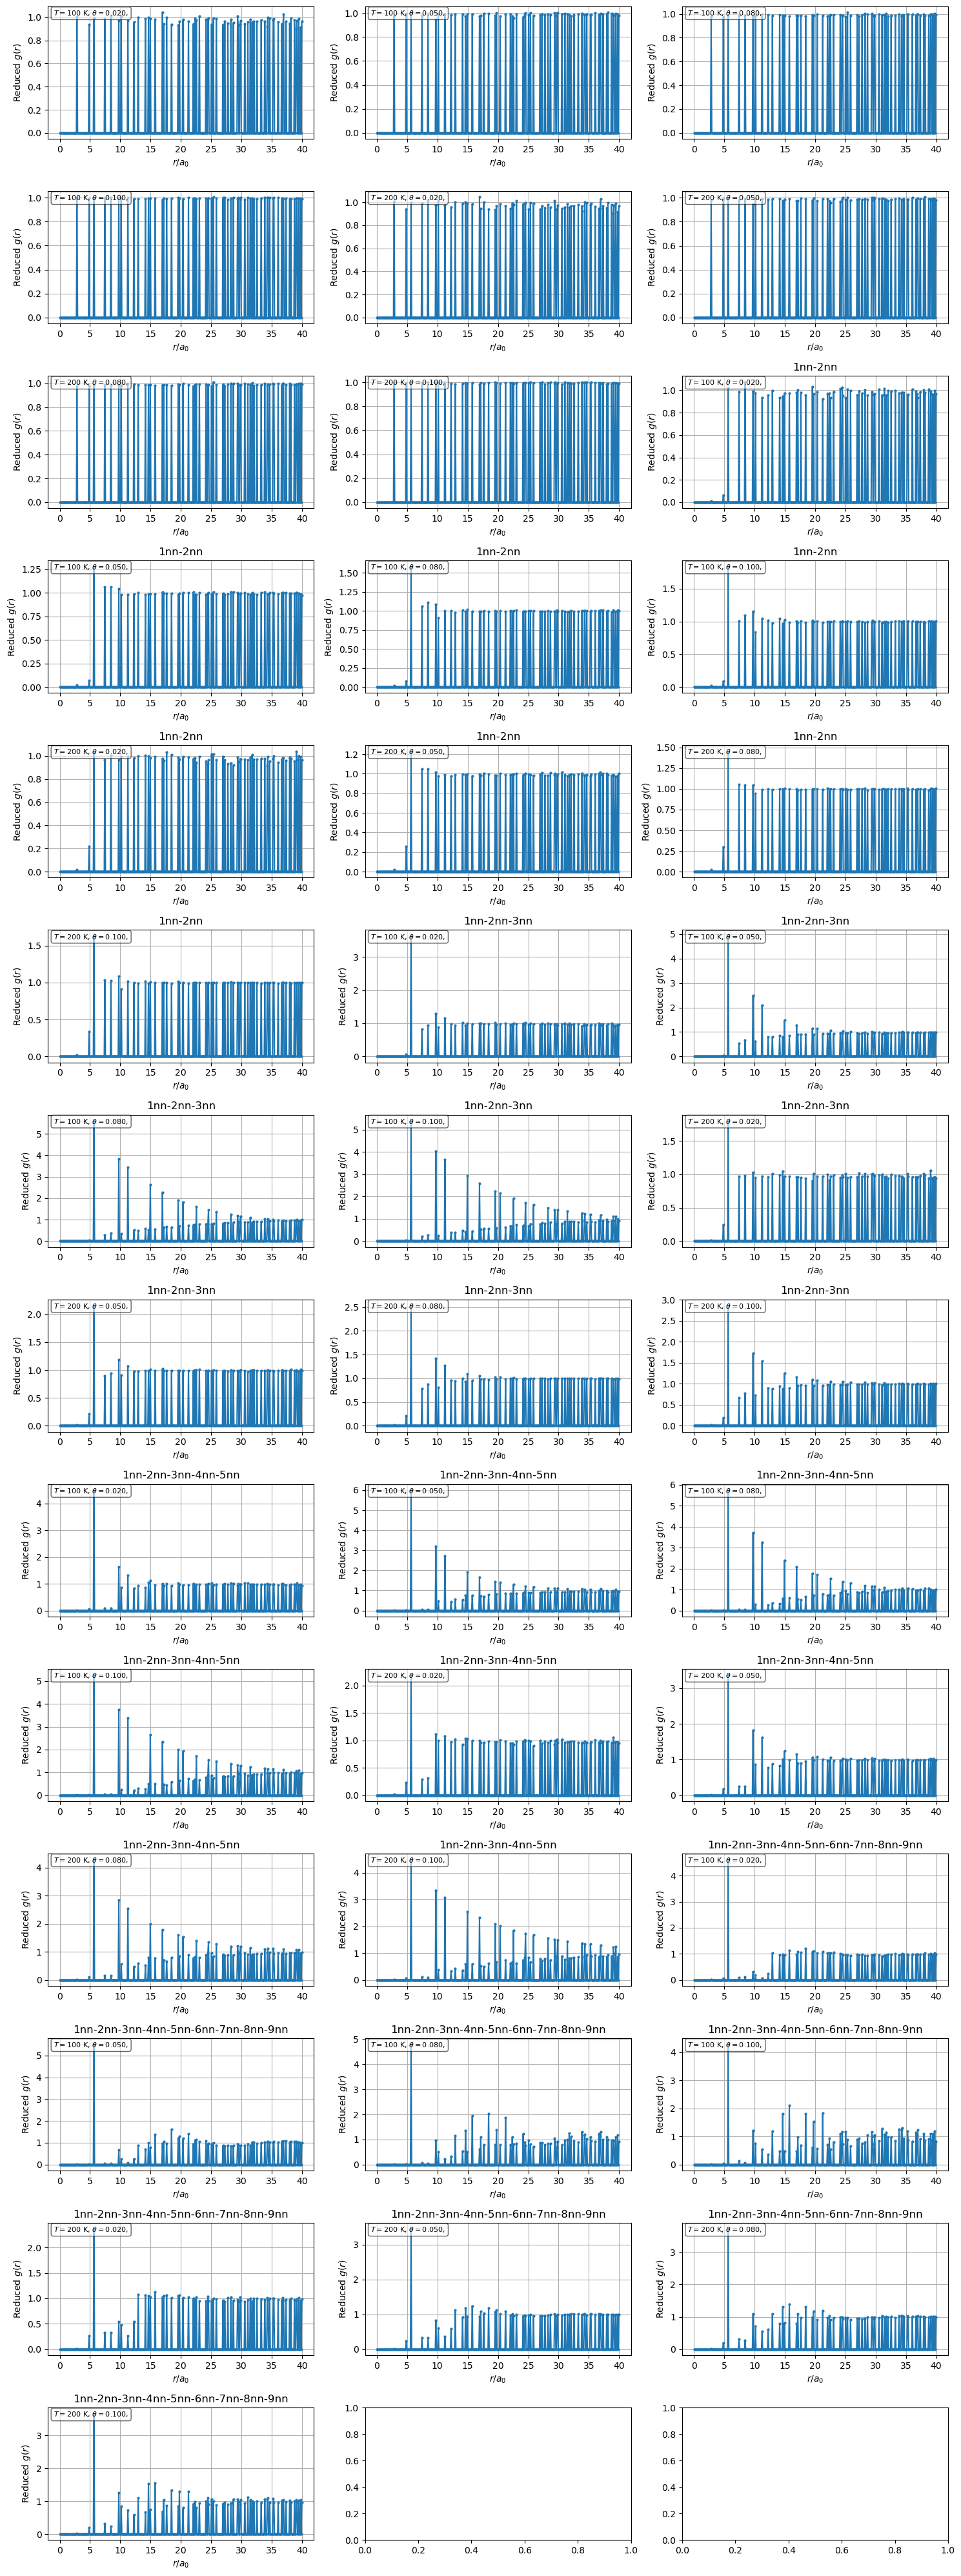

In [5]:
# Set the starting point for equilibrium from the averaged energy plots
fraction_eq = 0.5
# Consider extracting the lattice constant from zacros input files
lattice_constant = 2.821135
# RDF parameters
r_max = 40.0
dr    = 0.1
nbins = int(np.ceil(r_max / dr))

ncols = 3
fig_rdf, axes_rdf = plt.subplots(int(np.ceil(len(run_dirs)/ncols)), ncols, figsize=(15,40))

start_ir = 0
for irr,rundir in enumerate(run_dirs[start_ir:]):
   ir = irr + start_ir

   # Check if the run was analyzed
   if (results_dir / f'{rundir.name}_{zf.rdf_file_suffix}').exists():
      #print(f' Using the processed data from {results_dir} for {rundir.name}')
      r, g_avg = np.loadtxt(results_dir / f'{rundir.name}_{zf.rdf_file_suffix}', unpack=True)

   else:

      print(f' Processing trajectories from {rundir.name}...')
      # Get list of trajectories
      traj_files = list(rundir.rglob('history_output.txt'))

      # Get number of configurations
      nconfs = []
      for traj_file in traj_files:
         with open(traj_file) as f:
            for line in f: 
               if 'configuration' in line: 
                  confs = int(line.split()[1])
         nconfs.append(confs)

      g_avg = np.zeros(nbins)
      for traj_file, confs in zip(traj_files,nconfs):

         # Get lattice-site coordinates
         try:
            lattice = np.loadtxt(traj_file.parent / 'lattice_output.txt', usecols=(1,2),skiprows=2)
            with open(traj_file.parent / 'lattice_output.txt') as f:
               v1 = np.array(f.readline().split()[1:3], dtype=float)
               v2 = np.array(f.readline().split()[1:3], dtype=float)
            nsites  = len(lattice)
         except Exception:
            raise FileNotFoundError('lattice_output.txt not found in ' + str(traj_file.parent))
         
         # Get reference RDF for full coverage
         r, g_ref = zf.rdf([lattice], 1, v1, v2, 
                        lattice_constant=lattice_constant, r_max=r_max, dr=dr,
                        plot=False)

         # Get adsorbate positions
         ads_coords = zf.get_xy(traj_file.parent / 'lattice_input.dat')        

         # Get RDF averaged over configurations in trajectory
         r, g_traj = zf.rdf(ads_coords[:-int(fraction_eq*len(ads_coords))], 
                        coverages[ir], v1, v2, 
                        lattice_constant=lattice_constant, r_max=r_max, dr=dr,
                        g_ref=g_ref, plot=False)
         g_avg += g_traj / len(traj_files)

      # Save processed data
      np.savetxt(results_dir / f'{rundir.name}_{zf.rdf_file_suffix}', 
                 np.column_stack((r, g_avg)), 
                 header='r_Angstroem rdf_au')

   # Plot rdf using subplots
   ax = axes_rdf[ir//ncols, ir%ncols]
   ax.plot(r, g_avg, marker='o', linestyle='-', markersize=2)
   ax.set_xlabel(r'$r/a_0$')
   ax.set_ylabel('Reduced $g(r)$')
   ax.set_title(f'{interactions[ir]}')
   ax.text(0.02, 0.98, fr'$T={temperatures[ir]}$ K, $\theta={coverages[ir]:.3f}$, ',
             transform=ax.transAxes,
             va='top', ha='left',
             fontsize=8,
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.6))

   ax.grid()


fig_rdf.tight_layout()
#fig_rdf.show()

Cluster Size and Accessibility Distributions

In [ ]:
# Set the starting point for equilibrium from the averaged energy plots
fraction_eq = 0.5
# Consider extracting the lattice constant from zacros input files
lattice_constant = 2.821135
# Cluster accessibility parameters
nbins_acc  = 100

ncols = 3
# fig_csd, axes_csd = plt.subplots(int(np.ceil(len(run_dirs)/ncols)), ncols, figsize=(15,40))
# fig_acc, axes_acc   = plt.subplots(int(np.ceil(len(run_dirs)/ncols)), ncols, figsize=(15,40))
# fig_acch, axes_acch = plt.subplots(int(np.ceil(len(run_dirs)/ncols)), ncols, figsize=(15,40))

start_ir = 0
for irr,rundir in enumerate(run_dirs[start_ir:2]):
   ir = irr + start_ir

   # Check if the run was analyzed
   if (results_dir / f'{rundir.name}_{zf.csd_file_suffix}').exists():
      #print(f' Using the processed data from {results_dir} for {rundir.name}')
      csd_xs1, csd_avg1, acc_avg1 = np.loadtxt(results_dir / f'{rundir.name}_{zf.csd_file_suffix}', unpack=True)
      # ccd_x, ccd_avg    = np.loadtxt(results_dir / f'{rundir.name}_{zf.ccd_file_suffix}', unpack=True)
      acc_hx, acc_hist_avg    = np.loadtxt(results_dir / f'{rundir.name}_{zf.acc_file_suffix}', unpack=True)

   else:

      print(f' Processing trajectories from {rundir.name}...')
      # Get list of trajectories
      traj_files = list(rundir.rglob('history_output.txt'))

      # Get number of configurations
      nconfs = []
      for traj_file in traj_files:
         with open(traj_file) as f:
            for line in f: 
               if 'configuration' in line: 
                  confs = int(line.split()[1])
         nconfs.append(confs)

      # Get number of lattice sites from the first trajectory 
      try:
         lattice = np.loadtxt(traj_files[0].parent / 'lattice_output.txt', usecols=(1,2),skiprows=2)
         nsites  = len(lattice)
      except Exception:
         raise FileNotFoundError('lattice_output.txt not found in ' + str(traj_files[0].parent))
     
      csd_xs  = np.arange(nsites)
      csd_avg = np.zeros(nsites)
      acc_avg = np.zeros(nsites)
      # ccd_avg = np.zeros(nbins_circ)
      acc_hist_avg = np.zeros(nbins_acc)
      
      for traj_file, confs in zip(traj_files,nconfs):

         # Get lattice-site coordinates
         try:
            #lattice = np.loadtxt(traj_file.parent / 'lattice_output.txt', usecols=(1,2),skiprows=2)
            site_coordinates = []
            site_types = []
            site_coordinations = []
            site_nns = []
            with open(traj_file.parent / 'lattice_output.txt') as f:
               v1 = np.array(f.readline().split()[1:3], dtype=float)
               v2 = np.array(f.readline().split()[1:3], dtype=float)
               for line in f:
                  line_split = line.split()
                  site_coordinates.append(np.asarray(line_split[1,2]))
                  site_types.append(int(line_split[3]))
                  site_coordinations.append(int(line_split[4]))
                  site_nns.append([ int(line_split[4+i]) for i in range(site_coordinations[-1])])
            nsites  = len(site_types)
         except Exception:
            raise FileNotFoundError('lattice_output.txt not found in ' + str(traj_file.parent))
         
         # Get adsorbate positions and sites
         ads_info = get_ads_info(traj_file.parent)

         # Get cluster size and accessibilities distribution
#         csd_x, csd_y, ccd_x, ccd_y = zf.cluster_circularity_periodic_avg(
#                                       ads_coords[:-int(fraction_eq*len(ads_coords))], 
#                                       v1, v2, 2.01*lattice_constant, nbins=nbins_circ)
         print(f'  file {traj_file}')
         csd_y, acc_y, acc_hx, acc_hy  = cluster_accessibility_periodic_avg(
                                       ads_info[int(fraction_eq*len(ads_coords)):], 
                                       v1, v2, 2.01*lattice_constant, nbins=nbins_acc)
        

         # Accumulate distributions
         csd_avg += csd_y
         acc_avg += acc_y
         acc_hist_avg += acc_hy


      # Normalize averages
      csd_avg      /= len(traj_files)
      acc_avg      /= len(traj_files)
      acc_hist_avg /= len(traj_files)


      # Cut off zero entries from csd
      last_nz = np.flatnonzero(csd_avg)[-1] + 1

      csd_xs1 = csd_xs[:last_nz]
      csd_avg1 = csd_avg[:last_nz]
      acc_avg1 = acc_avg[:last_nz]
      # Save processed data
      #np.savetxt(results_dir / f'{rundir.name}_{zf.csd_file_suffix}', 
      #           np.column_stack((csd_xs1, csd_avg1, acc_avg1)), 
      #           header='size csd_counts acc_counts')
      # np.savetxt(results_dir / f'{rundir.name}_{zf.ccd_file_suffix}', 
      #           np.column_stack((ccd_x, ccd_avg)), 
      #           header='circularity average_counts')
      #np.savetxt(results_dir / f'{rundir.name}_{zf.acc_file_suffix}', 
      #           np.column_stack((acc_hx, acc_hist_avg)), 
      #           header='accessibility counts')


 Processing trajectories from 1...
  file /home/akandra/O_Pt111/zacros_calculations/jobs/1/traj_9/history_output.txt
v1: [2.821135 0.      ]
v2: [1.4105675  2.44317458]
cutoff: 5.670481349999999
points:
[[  7.0528375   10.58708984]
 [ 50.78043     81.43915258]
 [ 16.92681      8.14391526]
 [ 67.70724     91.21185089]
 [ 40.9064575   35.01883561]
 [ 31.032485     3.2575661 ]
 [ 73.34951     66.78010512]
 [ 86.0446175   69.2232797 ]
 [ 55.0121325    5.70074068]
 [ 84.63405     57.00740681]
 [ 97.3291575   78.99597801]
 [ 78.99178     42.34835934]
 [ 62.06497      8.14391526]
 [110.024265    91.21185089]
 [ 69.1178075   15.47343899]
 [ 76.170645    27.68931188]
 [107.20313     76.55280343]
 [ 76.170645    17.91661357]
 [102.9714275   64.33693054]
 [105.7925625   59.45058139]
 [ 91.6868875   30.13248646]
 [ 78.99178      3.2575661 ]
 [ 93.097455    22.80296272]
 [125.5405075   69.2232797 ]
 [ 95.91859     13.03026441]
 [117.0771025   49.67788308]
 [114.2559675   39.90518477]
 [125.5405075 

TypeError: only integer scalar arrays can be converted to a scalar index

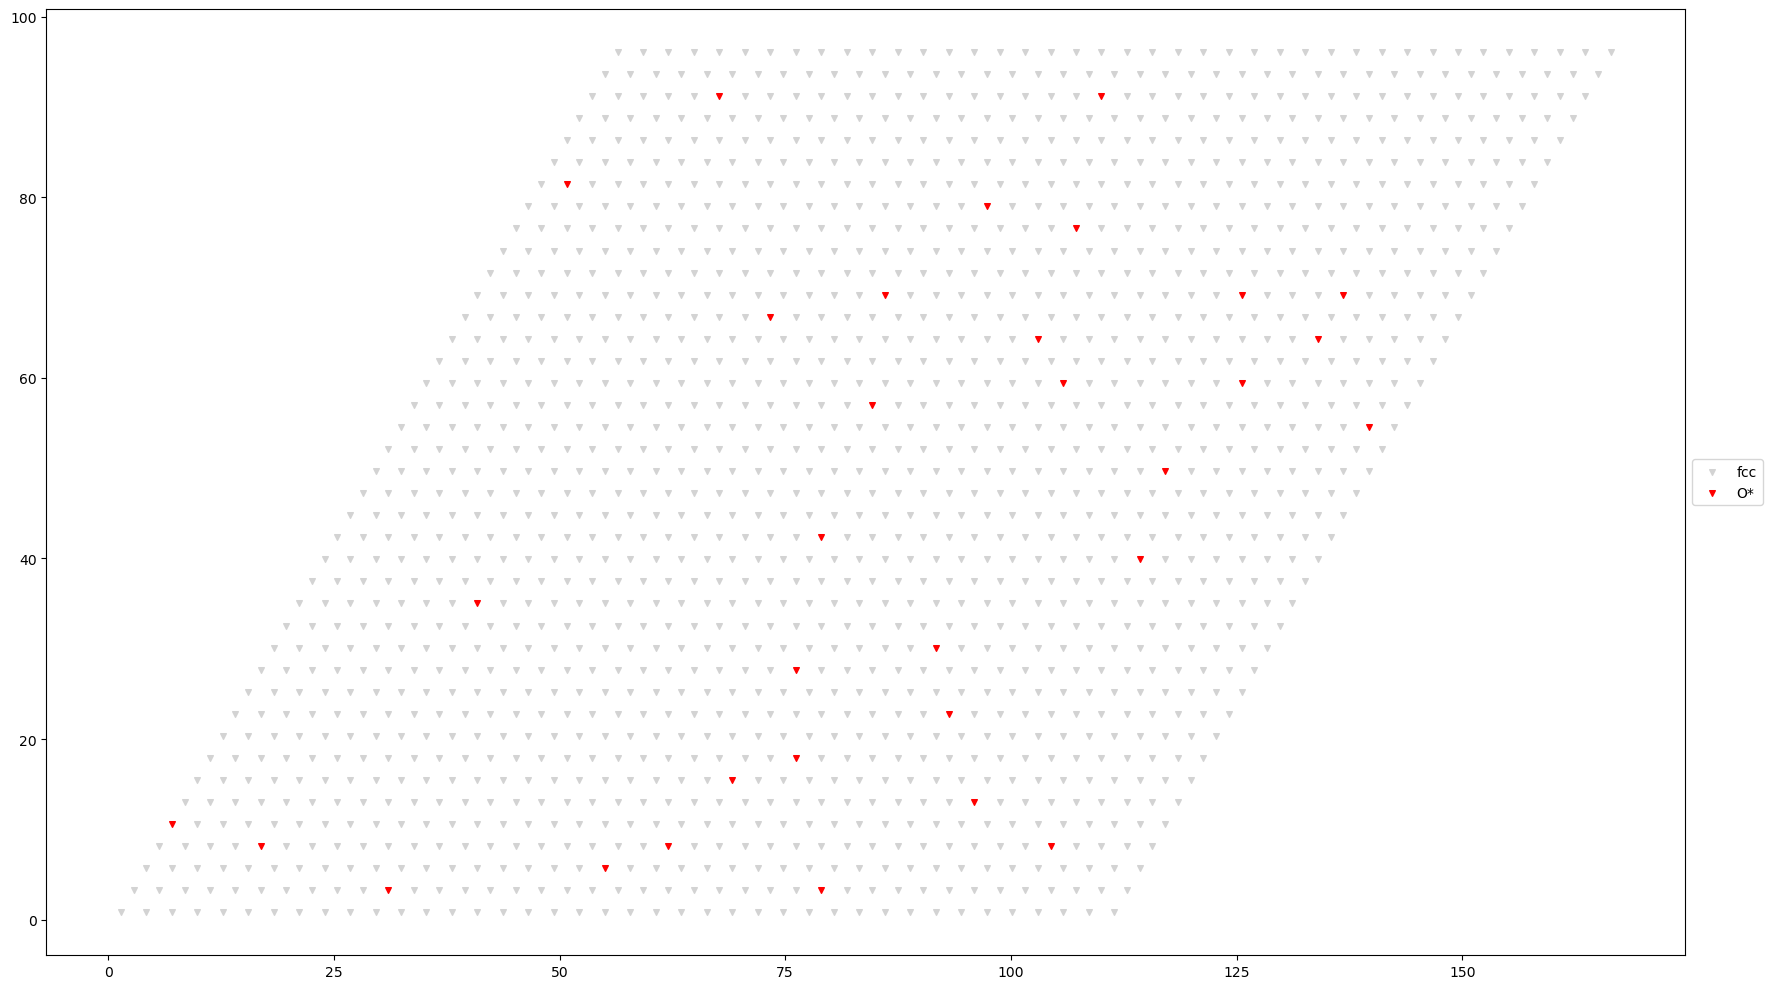

In [35]:
zf.lattice_plot( Path('/home/akandra/O_Pt111/zacros_calculations/jobs/1') / 'traj_9/lattice_input.dat',figsize=(18,10),idx=0)

In [ ]:
 6        45        44         4      1565      1566

In [ ]:

   # Plot csd using subplots
   ax = axes_csd[ir//ncols, ir%ncols]
   ax.plot(csd_xs1, csd_avg1, marker='o', linestyle='-', markersize=2)
   ax.set_xlabel(r'Size')
   ax.set_ylabel('csd average counts')
   ax.set_title(f'{interactions[ir]}')
   ax.text(0.02, 0.98, fr'$T={temperatures[ir]}$ K, $\theta={coverages[ir]:.3f}$, ',
             transform=ax.transAxes,
             va='top', ha='left',
             fontsize=8,
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.6))

   ax.grid()

   # Plot acc using subplots
   ax = axes_acc[ir//ncols, ir%ncols]
   ax.plot(csd_xs1, acc_avg1, marker='o', linestyle='-', markersize=2)
   ax.set_xlabel(r'Size')
   ax.set_ylabel('acc average counts')
   ax.set_title(f'{interactions[ir]}')
   ax.text(0.02, 0.98, fr'$T={temperatures[ir]}$ K, $\theta={coverages[ir]:.3f}$, ',
             transform=ax.transAxes,
             va='top', ha='left',
             fontsize=8,
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.6))

   ax.grid()

   # Plot acc histogram using subplots
   ax = axes_acch[ir//ncols, ir%ncols]
   ax.plot(acc_hx[:], acc_hist_avg[:], marker='o', linestyle='-', markersize=2)
   ax.set_xlabel(r'Accessibility')
   ax.set_ylabel('Average counts')
   ax.set_title(f'{interactions[ir]}')
   ax.text(0.02, 0.98, fr'$T={temperatures[ir]}$ K, $\theta={coverages[ir]:.3f}$, ',
             transform=ax.transAxes,
             va='top', ha='left',
             fontsize=8,
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.6))

   ax.grid()

fig_csd.tight_layout()
fig_acc.tight_layout()
fig_acch.tight_layout()
#fig_csd.show()
#fig_ccd.tight_layout()
#fig_ccd.show()

In [6]:
df = pd.DataFrame({
    'dir': run_dirs,
    'temperature': temperatures,
    'latsize': lat_size,
    'nads': n_ads,
    'int': interactions,
    'cov': coverages
})

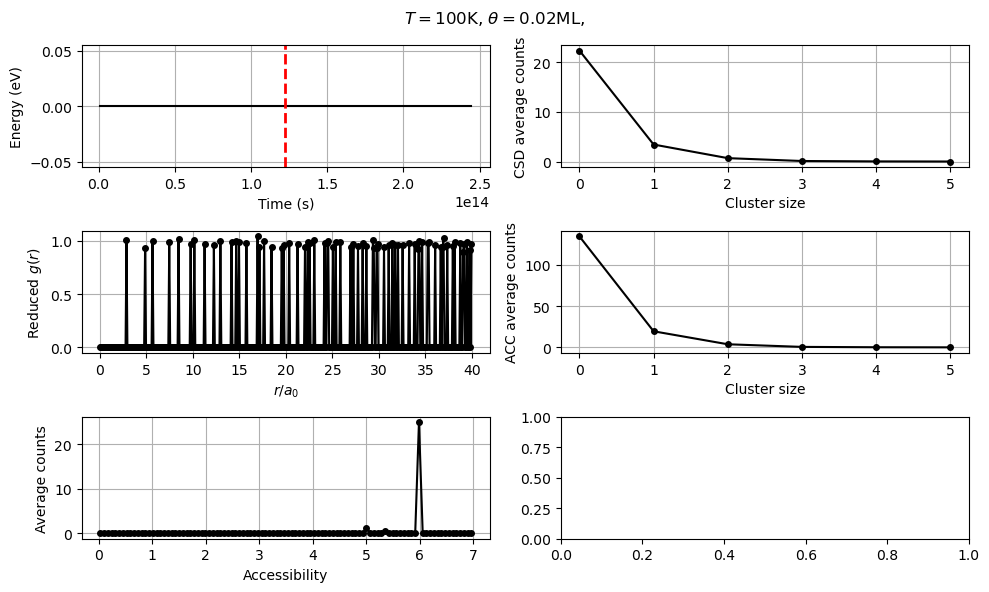

In [34]:
rundir = zf.plot_avgs(df, temperature=100, cov = 0.02, ints='',fraction_eq=fraction_eq,figsize=(10,6))

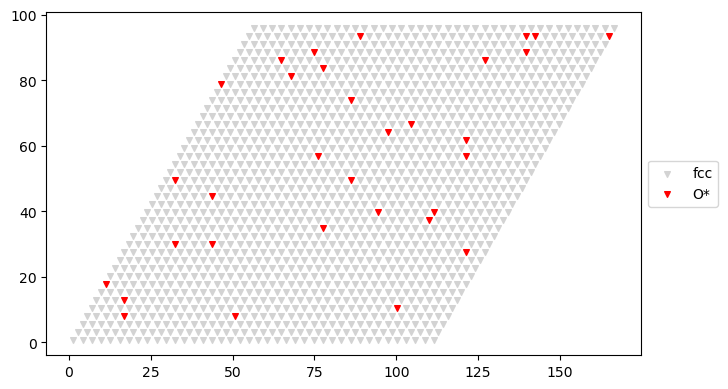

In [37]:
zf.lattice_plot(rundir / 'traj_1/lattice_input.dat',figsize=(8,4),idx=11)

In [ ]:
def get_xy(fname):
   try:
      return np.loadtxt(fname, unpack=True)
   except :
      return None,None

def plot_csds(df, temperature=[300], cov=[0.01], ints=[''], overlay=True):

   # Get the number of data to plot
   data = []
   cond_list = []
   for T in temperature:
      for c in cov:
         for i in ints:

            # Get df rows satisfying the conditions
            conditions = (df['int'] == i) & (df['temperature'] == T) & (df['cov'] == c)
            # Ignore not existing data
            if len(df[conditions]) > 0:
               # Get run data dir name
               rundir = df[conditions].dir.iloc[0] 
               fname = rundir.parent.parent / 'results' / f'{rundir.name}_{zf.csd_file_suffix}'
               x, y = get_xy(fname)
               if x is not None: 
                  data.append([x, y])
                  cond_list.append([T, c, i])

   if overlay:
      nrows, ncols = 1, 1
      figsize = (8,4)
   else:
      ncols = 3
      nrows = int(np.ceil(len(data)/ncols))
      figsize = (15,4*nrows)

   fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
   fig.suptitle('Comparing CSDs')

   for i, d in enumerate(data):

      if overlay:
         ax = axes
      else:
         if len(data) > ncols:
            ax = axes[i//ncols, i%ncols]
         else:
            ax = axes[i]

      ax.plot(d[0], d[1], marker='o', linestyle='-', markersize=4, 
              label=fr'{cond_list[i][0]}K, {cond_list[i][1]}ML, {cond_list[i][2]}')
      ax.grid()

      ax.set_xlabel(r'Cluster size')
      ax.set_ylabel('Average counts')

      ax.legend()

   fig.tight_layout()
   plt.show()
   
   return

def plot_ccds(df, temperature=[300], cov=[0.01], ints=[''], overlay=True):

   # Get the number of data to plot
   data = []
   cond_list = []
   for T in temperature:
      for c in cov:
         for i in ints:

            # Get df rows satisfying the conditions
            conditions = (df['int'] == i) & (df['temperature'] == T) & (df['cov'] == c)
            # Ignore not existing data
            if len(df[conditions]) > 0:
               # Get run data dir name
               rundir = df[conditions].dir.iloc[0] 
               fname = rundir.parent.parent / 'results' / f'{rundir.name}_{zf.ccd_file_suffix}'
               x, y = get_xy(fname)
               if x is not None: 
                  data.append([x, y])
                  cond_list.append([T, c, i])

   if overlay:
      nrows, ncols = 1, 1
      figsize = (8,4)
   else:
      ncols = 3
      nrows = int(np.ceil(len(data)/ncols))
      figsize = (15,4*nrows)

   fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
   fig.suptitle('Comparing CCDs')

   for i, d in enumerate(data):

      if overlay:
         ax = axes
      else:
         if len(data) > ncols:
            ax = axes[i//ncols, i%ncols]
         else:
            ax = axes[i]

      ax.plot(d[0][1:], d[1][1:], marker='o', linestyle='-', markersize=4, 
              label=fr'{cond_list[i][0]}K, {cond_list[i][1]}ML, {cond_list[i][2]}')
      ax.grid()

      ax.set_xlabel(r'Circularity')
      ax.set_ylabel('Average counts')

      ax.legend()

   fig.tight_layout()
   plt.show()
   
   return

def plot_rdfs(df, temperature=[300], cov=[0.01], ints=[''], overlay=False):

   # Get the number of data to plot
   data = []
   cond_list = []
   for T in temperature:
      for c in cov:
         for i in ints:

            # Get df rows satisfying the conditions
            conditions = (df['int'] == i) & (df['temperature'] == T) & (df['cov'] == c)
            # Ignore not existing data
            if len(df[conditions]) > 0:
               # Get run data dir name
               rundir = df[conditions].dir.iloc[0] 
               fname = rundir.parent.parent / 'results' / f'{rundir.name}_{zf.rdf_file_suffix}'
               x, y = get_xy(fname)
               if x is not None: 
                  data.append([x, y])
                  cond_list.append([T, c, i])

   if overlay:
      nrows, ncols = 1, 1
      figsize = (8,4)
   else:
      ncols = 3
      nrows = int(np.ceil(len(data)/ncols))
      figsize = (15,4*nrows)

   fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
   fig.suptitle('Comparing RDFs')

   ymax = max([ max(d[1]) for d in data])
   for i, d in enumerate(data):

      if overlay:
         ax = axes
      else:
         if len(data) > ncols:
            ax = axes[i//ncols, i%ncols]
         else:
            ax = axes[i]

      ax.plot(d[0], d[1], marker='o', linestyle='-', markersize=4, 
              label=fr'{cond_list[i][0]}K, {cond_list[i][1]}ML, {cond_list[i][2]}')
      ax.set_ylim(-0.1*ymax,1.1*ymax)
      ax.grid()

      ax.set_xlabel(r'$r/a_0$')
      ax.set_ylabel('Reduced $g(r)$')

      ax.legend()

   fig.tight_layout()
   plt.show()
   
   return

def plot_ens(df, temperature=[300], cov=[0.01], ints=[''], overlay=True):

   # Get the number of data to plot
   data = []
   cond_list = []
   for T in temperature:
      for c in cov:
         for i in ints:

            # Get df rows satisfying the conditions
            conditions = (df['int'] == i) & (df['temperature'] == T) & (df['cov'] == c)
            # Ignore not existing data
            if len(df[conditions]) > 0:
               # Get run data dir name
               rundir = df[conditions].dir.iloc[0] 
               fname = rundir.parent.parent / 'results' / f'{rundir.name}_{zf.en_file_suffix}'
               x, y = get_xy(fname)
               if x is not None: 
                  data.append([x, y])
                  cond_list.append([T, c, i])

   if overlay:
      nrows, ncols = 1, 1
      figsize = (8,4)
   else:
      ncols = 3
      nrows = int(np.ceil(len(data)/ncols))
      figsize = (15,3*nrows)

   fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
   fig.suptitle('Comparing Energy')

   for i, d in enumerate(data):

      if overlay:
         ax = axes
      else:
         if len(data) > ncols:
            ax = axes[i//ncols, i%ncols]
         else:
            ax = axes[i]

      ax.plot(d[0][1:], d[1][1:], marker='o', linestyle='-', markersize=4, 
              label=fr'{cond_list[i][0]}K, {cond_list[i][1]}ML, {cond_list[i][2]}')
      ax.grid()

      ax.set_xlabel('Time (s)')
      ax.set_ylabel('Energy (eV)')

      ax.legend()

   fig.tight_layout()
   plt.show()
   
   return

def plot_accs(df, temperature=[300], cov=[0.01], ints=[''], overlay=True):

   # Get the number of data to plot
   data = []
   cond_list = []
   for T in temperature:
      for c in cov:
         for i in ints:

            # Get df rows satisfying the conditions
            conditions = (df['int'] == i) & (df['temperature'] == T) & (df['cov'] == c)
            # Ignore not existing data
            if len(df[conditions]) > 0:
               # Get run data dir name
               rundir = df[conditions].dir.iloc[0] 
               fname = rundir.parent.parent / 'results' / f'{rundir.name}_{zf.ccd_file_suffix}'
               x, y = get_xy(fname)
               if x is not None: 
                  data.append([x, y])
                  cond_list.append([T, c, i])

   if overlay:
      nrows, ncols = 1, 1
      figsize = (8,4)
   else:
      ncols = 3
      nrows = int(np.ceil(len(data)/ncols))
      figsize = (15,4*nrows)

   fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
   fig.suptitle('Comparing CCDs')

   for i, d in enumerate(data):

      if overlay:
         ax = axes
      else:
         if len(data) > ncols:
            ax = axes[i//ncols, i%ncols]
         else:
            ax = axes[i]

      ax.plot(d[0][1:], d[1][1:], marker='o', linestyle='-', markersize=4, 
              label=fr'{cond_list[i][0]}K, {cond_list[i][1]}ML, {cond_list[i][2]}')
      ax.grid()

      ax.set_xlabel(r'Circularity')
      ax.set_ylabel('Average counts')

      ax.legend()

   fig.tight_layout()
   plt.show()
   
   return

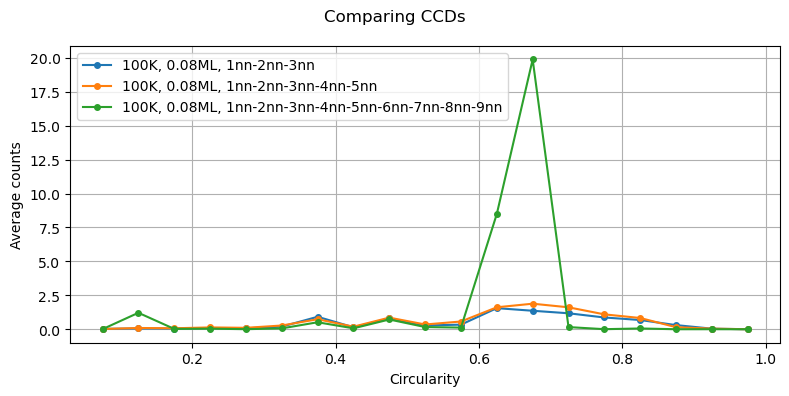

In [30]:
plot_ccds(df, temperature=[100], cov=[0.08], ints=sorted(set(df.int))[2:], overlay=True)

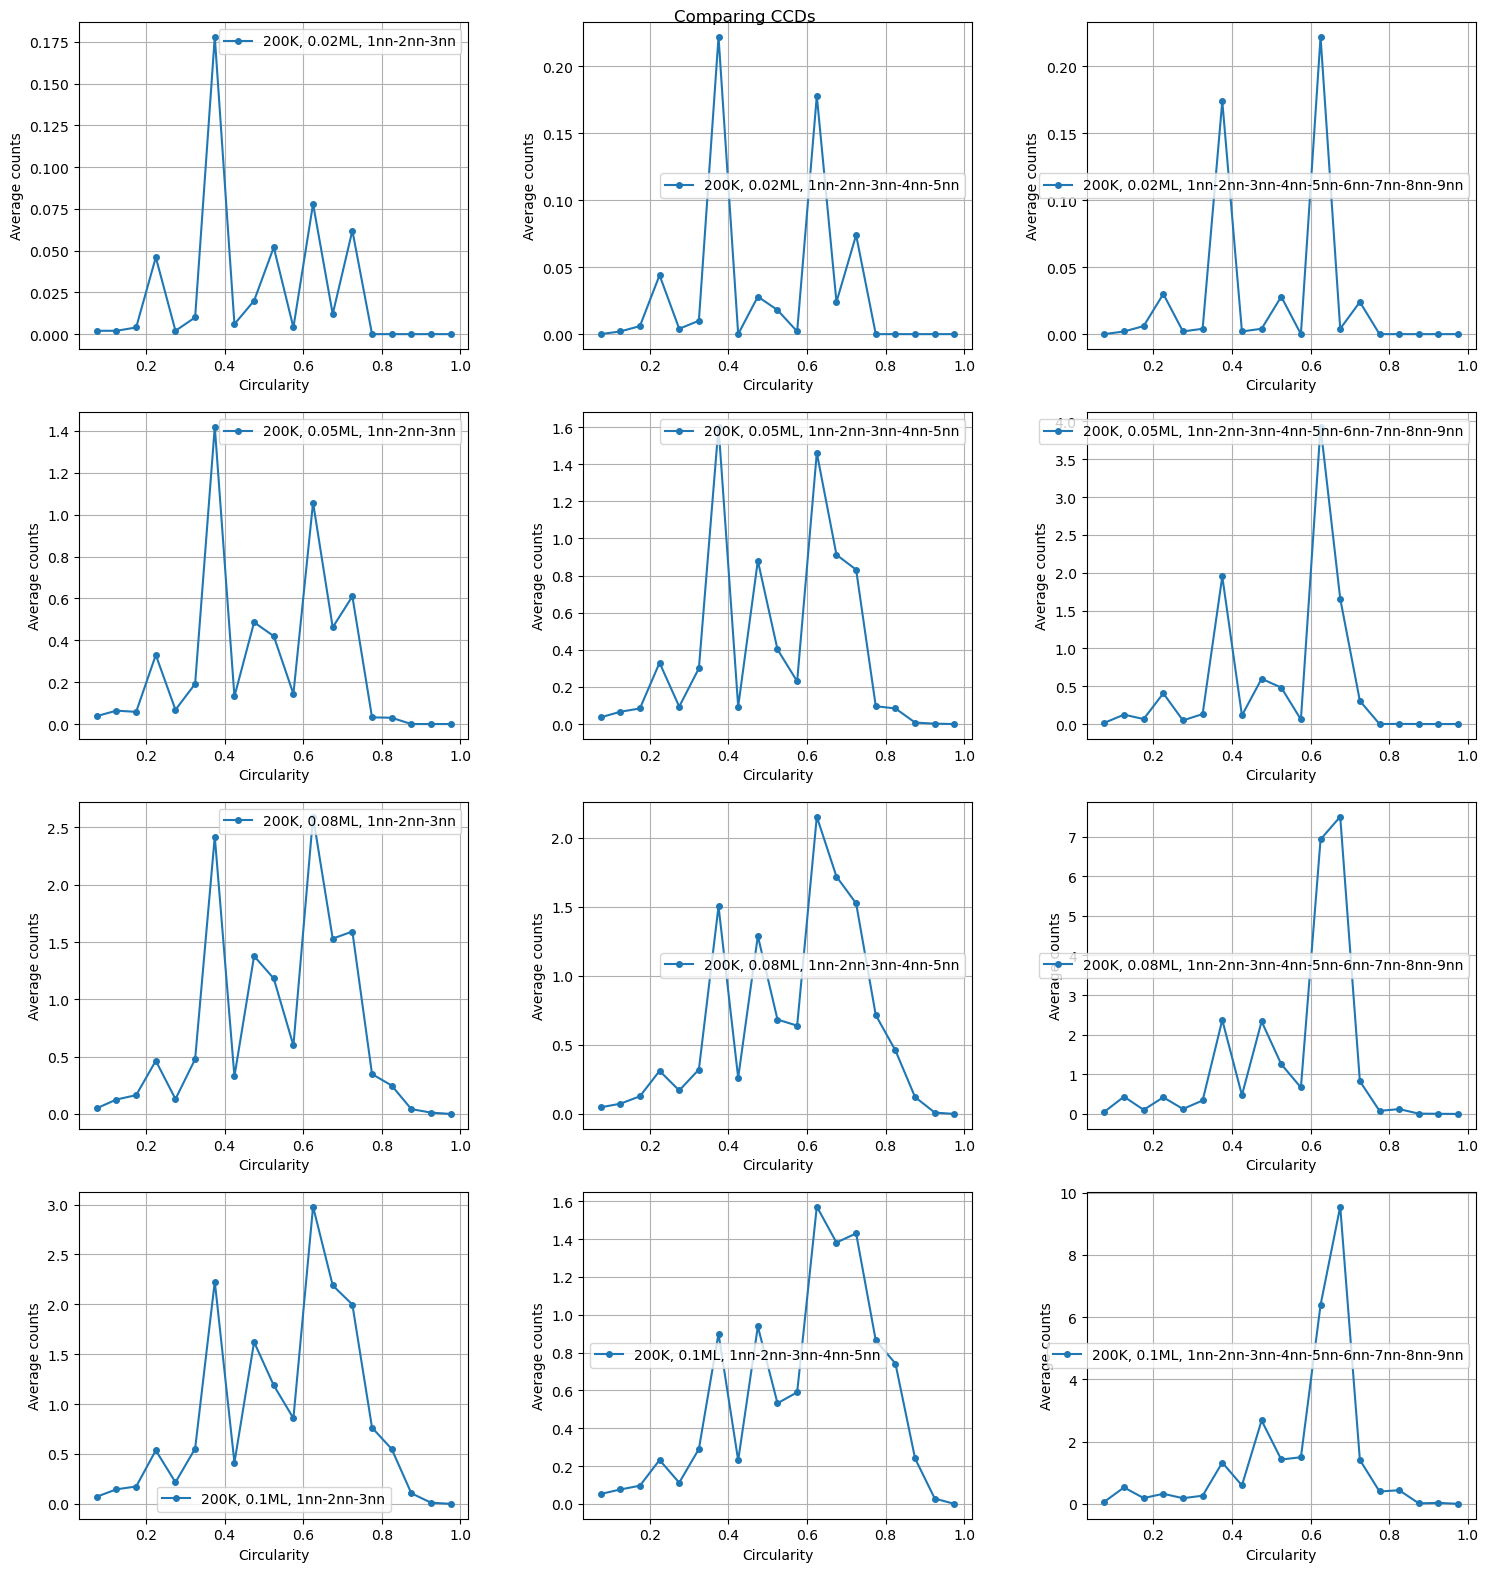

In [83]:
plot_ccds(df, temperature=[200], cov=sorted(set(df.nads/df.latsize.iloc[0])), ints=sorted(set(df.int))[2:], overlay=False)

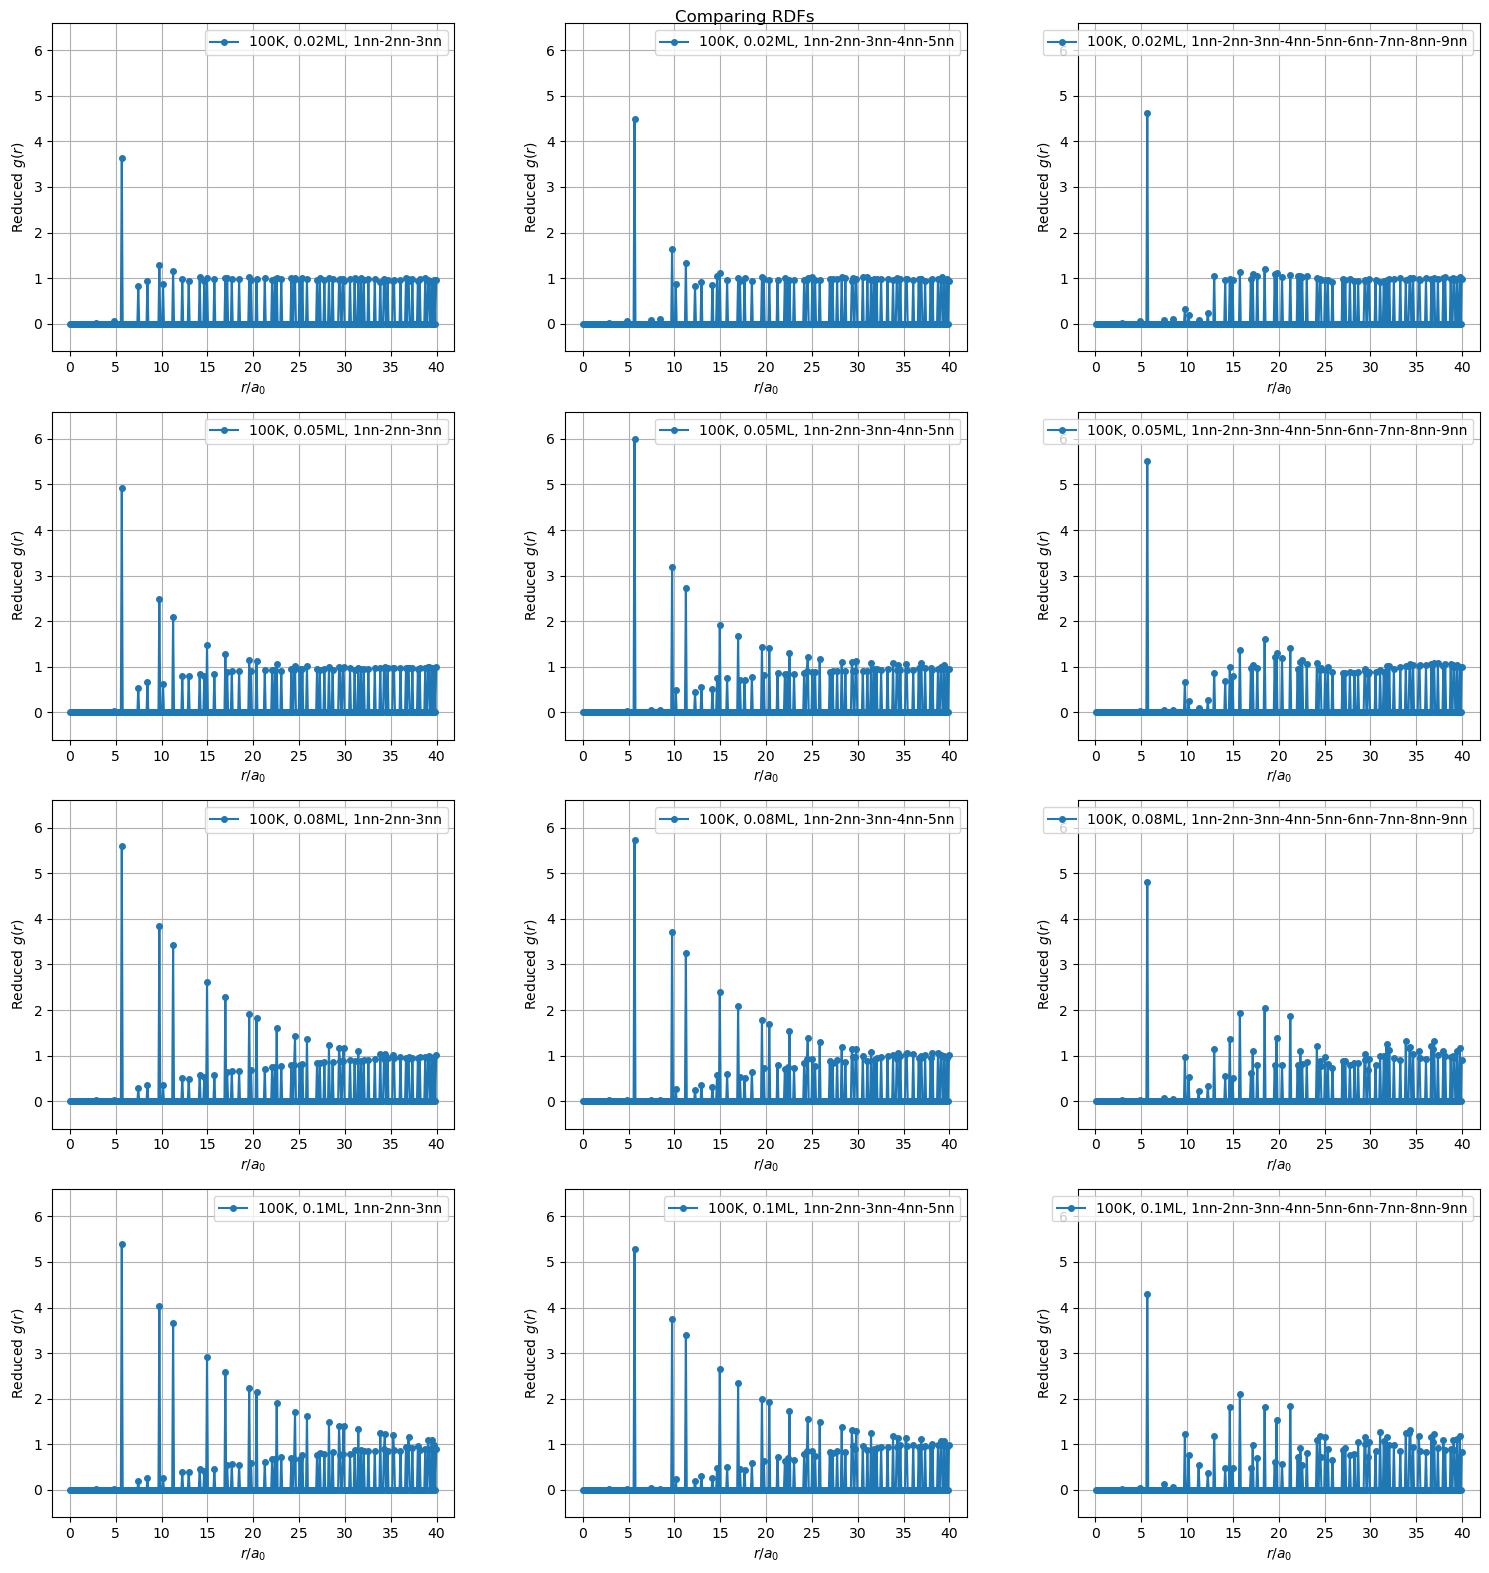

In [65]:
plot_rdfs(df, temperature=[100], cov=sorted(set(df.nads/df.latsize.iloc[0])), ints=sorted(set(df.int))[2:], overlay=False)

In [4]:
rundir = zf.plot_avgs(df, temperature=100, cov = 0.02, int='',fraction_eq=fraction_eq,figsize=(6,4))

NameError: name 'zf' is not defined

In [3]:
zf.lattice_plot(rundir / 'traj_1/lattice_input.dat',figsize=(8,4),idx=99)

NameError: name 'zf' is not defined

In [ ]:
cluster_accessibility_periodic_avg(
                                       ads_coords[:-int(fraction_eq*len(ads_coords))], 
                                       v1, v2, nsites, 2.0*lattice_constant, tolerance=0.01, nbins=nbins_acc)

In [139]:
points = zf.get_xy(rundir / 'traj_1/lattice_input.dat', idx=99)
sites, v1, v2  = get_lattice_xy(rundir / 'traj_1/')
labels, clusters, sizes = zf.cluster_points_periodic(points[0], v1, v2,  2.01*lattice_constant)
accessibilities = get_accessibility(points[0], v1, v2, 2.0*lattice_constant, tolerance=0.001)
print(len(points[0]), len(sites), len(labels),len(clusters),len(sizes))
print(labels)
print(clusters)
print(accessibilities)
print(np.sum(accessibilities)/len(accessibilities))
print(np.sum(accessibilities[accessibilities < 6])/len(accessibilities))

160 1600 160 21 21
[ 0  0  0  0  0  0  0 10 10  0  0  0  0  1  0  0  2 10  0  0  0  0  1  0
  0 10  0  0  0  0  0  3  0  0  4  0  0  0  0  5  0  0  0  0  0  0  6  7
  7  0  0  0  7  8 10  7  9 10 11 10 10 10 10 12 13 14 10 10 12 14 10 10
 10 10 10 10 10 10 10 15 16 19 17 10 10 10 10 10 10 19 17 10 10 10 10 10
 10 18 19 19 19 10 10 10 10 10 10 10 18 19 19 19 19 10 10 10 10 10 10 10
 10 10 10 10 19 19 19 10 10 10 10 10 10 10 10 10 10 20 10 10 10 10 10 10
  0 10 10 10 10 10  0  0  0  0  0 10 10 10 10 10]
[array([  0,   1,   2,   3,   4,   5,   6,   9,  10,  11,  12,  14,  15,
        18,  19,  20,  21,  23,  24,  26,  27,  28,  29,  30,  32,  33,
        35,  36,  37,  38,  40,  41,  42,  43,  44,  45,  49,  50,  51,
       144, 150, 151, 152, 153, 154]), array([13, 22]), array([16]), array([31]), array([34]), array([39]), array([46]), array([47, 48, 52, 55]), array([53]), array([56]), array([  7,   8,  17,  25,  54,  57,  59,  60,  61,  62,  66,  67,  70,
        71,  72,  73,  74,  75, 